# Experiments for Different decompositions (SLIC Algorithm)

## 1. Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
from skimage.segmentation import mark_boundaries
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim
from numpy.linalg import norm
import os

# Importing Dependencies
from superpixel import superpixel, centroid, highway_pixel,coherence_estimator, oneD_regionProp, centroid_single, coherence_estimator_super
from decomposition_experiment import decomposition_highway, decomposition_super, decomposition_highway1, decomposition_super1
from decomposition_experiment import decomposition_highway2, decomposition_super2, decomposition_highway3, decomposition_super3
from metrics import calculate_metrics, display_result
from utils import readFloatComplex, readShortComplex, readFloat

# Path to save the results
path = r'outputs\slic'

# Path to read the data from
base = r"data1"

# Width of input image
WIDTH = 300

# Number of clusters in the Stage II Super pixeling
k=600

## 2. Loading the data

In [2]:
# Loading dataset 1
IFG_PATH = os.path.join(base,"1slc1_1slc2.noisy")
COH_PATH = os.path.join(base,"1slc1_1slc2.filt.coh")
SLC1_PATH = os.path.join(base,"1slc1.rslc")
SLC2_PATH = os.path.join(base,"1slc2.rslc")

ifg = readFloatComplex(IFG_PATH, WIDTH)
coh_3vg = readFloat(COH_PATH, WIDTH)
slc1 = readFloatComplex(SLC1_PATH, WIDTH)
slc2 = readFloatComplex(SLC2_PATH, WIDTH)

# Loading Dataset 2
i = 0
# ifg = np.load(os.path.join(base,str(i)+".ifg.npy"))[:300,:300]
# coh_3vg = np.load(os.path.join(base,str(i)+".coh.npy"))[:300,:300]
# slc1 = np.load(os.path.join(base,str(i)+".slc1.npy"))[:300,:300]
# slc2 = np.load(os.path.join(base,str(i)+".slc2.npy"))[:300,:300]

## 3. Preprocessing Input

In [3]:
# Creating the 4-channel input 

# Dim-0
amp_slc1 = np.abs(slc1)

# Dim-1
amp_slc2 = np.abs(slc2)

# Phase of Ifg
phase_ifg = np.angle(ifg)

# Force amp to one
phase_bar_ifg = 1*np.exp(1j*phase_ifg)

# Dim-2
real_ifg_phase = np.real(phase_bar_ifg)
# Dim-3
imag_ifg_phase = np.imag(phase_bar_ifg)

# Stacking each dimension in each channel
input = np.dstack((amp_slc1,amp_slc2,real_ifg_phase,imag_ifg_phase))
print("Input Shape:",input.shape)

Input Shape: (300, 300, 4)


## 4. Stage 1 Super pixeling

In [4]:
# Calling super pixeling algorithms
superpixel_fz,superpixel_slic=superpixel(input)

C:\Users\daley\Anaconda3\lib\site-packages\skimage\segmentation\_felzenszwalb.py:64: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  min_size=min_size)


Felzenszwalb number of Super Pixels: 6367
SLIC number of Super Pixels: 5625


In [5]:
# Selecting the super pixel algorithm
super_pixel = superpixel_slic
print("Size of Super pixel:",np.array(super_pixel).shape)

Size of Super pixel: (300, 300)


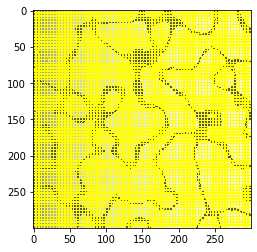

In [6]:
# Displaying the super pixel boundaries
plt.imshow(mark_boundaries(coh_3vg, super_pixel))

In [7]:
# Finding the Cluster centroids along each channel and stacked
centroids_super,a1_list,a2_list,real_list,imag_list,coordinates_super = centroid(super_pixel,input)

# Stacking the input for Stage II Super pixeling
input_super = np.dstack((a1_list,a2_list,real_list,imag_list))
print("Size of input to highway: ",input_super.shape)

Size of input to highway:  (1, 5625, 4)


## 5. Stage II Super Pixeling

In [8]:
# Stage II super pixeling using K-means
kmeans = KMeans(n_clusters=k, random_state=0).fit(input_super.reshape(-1,4))
highway = kmeans.labels_
print(f"Number of Highway Pixels: {len(np.unique(highway))}")

Number of Highway Pixels: 600


In [9]:
# Passing the highway cluster labels to pixel-level
new_input = highway_pixel(input,super_pixel,highway)

# Finding the centroid of highway pixel and each channel separately
centroids_highway,a1_list,a2_list,real_list,imag_list, coordinates_high = centroid_single(highway ,input_super)

## 6. Coherence Estimation using Maximum Liklihood Estimator

In [10]:
highway_coh = coherence_estimator(new_input,slc1,slc2)

## 7. Decomposition to Highway 

### Experiment 1. Inverse Distance Decomposition 

In [11]:
# Decomposing highway pixel to superpixel
decom_super_coh = decomposition_highway(centroids_highway, highway,highway_coh,coordinates_high,input_super)

# Decomposing super pixel to pixel-level
coh = decomposition_super(centroids_super,super_pixel,decom_super_coh,coordinates_super,input)

In [12]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh)


MSE 0.05947333706248807
RMSE 0.24387155853540624
SSIM: 0.4396132356910593


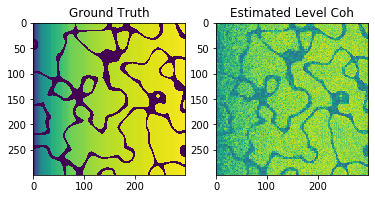

In [13]:
# Displaying the results
plt = display_result(coh_3vg, coh)
plt.savefig(os.path.join(path,"Experiment 1"))

### Experiment 2. Differential Decomposition with level-specific weight

In [14]:
# Decomposing highway pixel to superpixel
decom_super_coh = decomposition_highway1(centroids_highway, highway,highway_coh,coordinates_high,input_super)

# Decomposing super pixel to pixel-level
coh = decomposition_super1(centroids_super,super_pixel,decom_super_coh,coordinates_super,input)

In [15]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh)

MSE 0.039152098198281506
RMSE 0.19786889143642947
SSIM: 0.42558121508529867


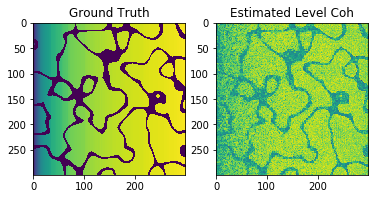

In [16]:
# Displaying the results
plt = display_result(coh_3vg, coh)
plt.savefig(os.path.join(path,"Experiment 2"))

### Experiment 3: Differential Decomposition with distance-specific weight

In [17]:
# Decomposing highway pixel to superpixel
decom_super_coh = decomposition_highway2(centroids_highway, highway,highway_coh,coordinates_high,input_super)

# Decomposing super pixel to pixel-level
coh = decomposition_super2(centroids_super,super_pixel,decom_super_coh,coordinates_super,input)

In [18]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh)

MSE 0.0803113954504965
RMSE 0.2833926524285633
SSIM: 0.2856036094966123


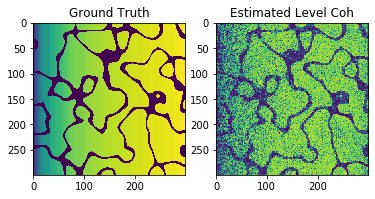

In [19]:
# Displaying the results
plt = display_result(coh_3vg, coh)
plt.savefig(os.path.join(path,"Experiment 3"))

### Experiment 4: Direct decomposition of highway coherence

In [20]:
# Decomposing highway pixel to superpixel
decom_super_coh = decomposition_highway3(centroids_highway, highway,highway_coh,coordinates_high,input_super)

# Decomposing super pixel to pixel-level
coh1 = decomposition_super3(centroids_super,super_pixel,decom_super_coh,coordinates_super,input)

In [21]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh1)

MSE 0.017489954470199128
RMSE 0.13224959156912028
SSIM: 0.7442258758020175


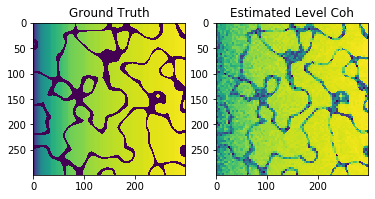

In [22]:
# Displaying the results
plt = display_result(coh_3vg, coh1)
plt.savefig(os.path.join(path,"Experiment 4"))

### Experiment 5: Direct decomposition of Super pixel coherence

In [23]:
# Estimating coherence at super pixel level
superpixel_coh = coherence_estimator_super(super_pixel,slc1,slc2)

(5625,)


In [24]:
coh2 = decomposition_super3(centroids_super,super_pixel,superpixel_coh,coordinates_super,input)

In [25]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh2)

MSE 0.021095041340164107
RMSE 0.1452413210493629
SSIM: 0.6823790591393535


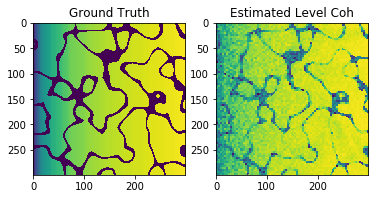

In [26]:
# Displaying the results
plt = display_result(coh_3vg, coh2)
plt.savefig(os.path.join(path,"Experiment 5"))

### Experiment 6: Combination of highway and super pixel direct decomposition

In [27]:
coh = (np.array(coh1)*np.array(coh2))**(1/2)

In [28]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh)

MSE 0.018209516885808526
RMSE 0.1349426429480634
SSIM: 0.731514158359095


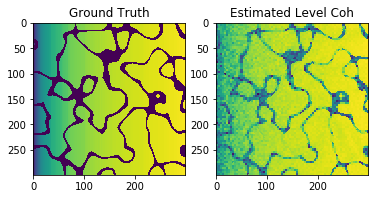

In [29]:
# Displaying the results
plt = display_result(coh_3vg, coh)
plt.savefig(os.path.join(path,"Experiment 6"))

## Comparison with Boxcar (Sliding Window)

In [30]:
def sliding_window(input, slc1,slc2,stepSize, windowSize):
    """
    Function to perform boxcar function on the input
    
    Args: 
    
    input: 4 channel input data on which boxcar needs to be performed
    slc1: First SAR Image
    slc2: Second SAR Image
    stepSize: Stride requuired for the sliding window
    windorSize: Size of sliding window
    
    Returns: 
    coh : Coherence estimate using sliding window
    """
    
    coh = np.zeros((300,300))
    
    # slide a window across the image
    for y in range(0, 300, stepSize):
        for x in range(0, 300, stepSize):
            
            # yield the current window
            window = input[y:y + windowSize[1], x:x + windowSize[0],:]
            
            # Getting the window on SAR Image 1 and 2
            z1 = slc1[y:y + windowSize[1], x:x + windowSize[0]]
            z2 = slc2[y:y + windowSize[1], x:x + windowSize[0]]

            # Coherence estimate using maximum liklihood estimator
            delta = np.abs(np.sum(z1*np.conj(z2))/np.sqrt(np.sum(np.abs(z1)**2.)*np.sum(np.abs(z2)**2.)))
            
            # Assigning pixel-wise coherence
            coh[x,y] = delta

    return np.transpose(coh)

### 1. Sliding window with size 7x7

In [31]:
# Padding the input with zeros for sliding window
data =np.pad(input, ((3,3), (3,3), (0, 0)), 'constant')

# Padding the SAR images with zeros for sliding window
s1 =np.pad(slc1, ((3,3), (3,3)), 'constant')
s2 =np.pad(slc2, ((3,3), (3,3)), 'constant')

# Calculating coherence using sliding window of size 7x7
coh = sliding_window(data,s1,s2,1,[7,7])

In [32]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh)

MSE 0.028602063522475595
RMSE 0.1691214460749304
SSIM: 0.6675259400664286


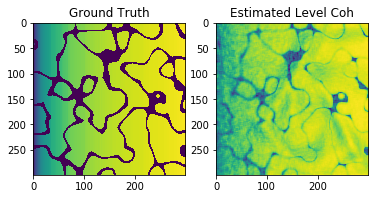

In [33]:
# Displaying the results
plt = display_result(coh_3vg, coh)
plt.savefig(os.path.join(path,"Sliding window 7x7"))

### 2. Sliding Window of size 5x5

In [34]:
# Padding the input with zeros for sliding window
data =np.pad(input, ((2,2), (2,2), (0, 0)), 'constant')

# Padding the SAR images with zeros for sliding window
s1 =np.pad(slc1, ((2,2), (2,2)), 'constant')
s2 =np.pad(slc2, ((2,2), (2,2)), 'constant')

# Calculating coherence using sliding window of size 5x5
coh = sliding_window(data,s1,s2,1,[5,5])

In [35]:
# Calculating evaluation metrics
mse,rmse,ssim = calculate_metrics(coh_3vg, coh)

MSE 0.02369686038663478
RMSE 0.15393784585551007
SSIM: 0.6766978026478203


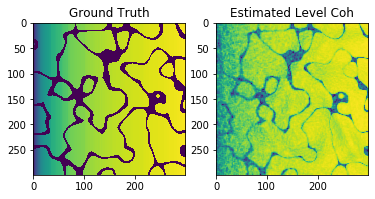

In [36]:
# Displaying the results
plt = display_result(coh_3vg, coh)
plt.savefig(os.path.join(path,"Sliding window 5x5"))

# End of Experiments